### Importing the libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

plt.rc('text', usetex=True)
plt.rc('font', family = 'serif', size = 10)
plt.rcParams["axes.linewidth"] = "2"

In [2]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [3]:
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams["xtick.minor.size"] = 4.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams["ytick.minor.size"] = 4.0

### Dowload the Dataset

In [4]:
# Transformation to be applied to the data - Conversion of data to PyTorch tensors and normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download of the Dataset
train_dataset = datasets.FashionMNIST(root='./Data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./Data', train=False, transform=transform, download=True)


### Creating the training and testing data loaders

In [5]:
# Creating the loaders for the training and testing datasets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualizing an image

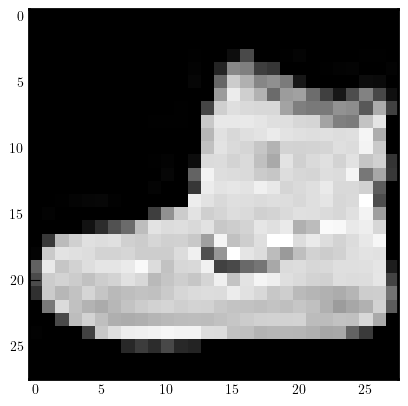

In [6]:
# Slecting the first image of the training dataset
image, label = train_dataset[0]

# Convert the image tensor to a NumPy array and unnormalize it
image = image.numpy() * 0.5 + 0.5

# Plot the image
plt.imshow(np.squeeze(image), cmap='gray')
plt.savefig('Image_1.pdf', bbox_inches='tight')

## Convolutional Neural Network

In [7]:
class CNN(nn.Module):
    def __init__(self, dropout_prob = 0, batch_norm = False, residual = False):
        super(CNN, self).__init__()

        torch.manual_seed(42)

        # Setting the dropout probability
        self.dropout_prob = dropout_prob

        # Setting the batch normalization flag
        self.batch_norm = batch_norm

        # Setting the residual flag
        self.residual = residual

        #Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(7*7*64,64)
        self.fc2 = nn.Linear(64,10)

        ## Xavier initialization of the parameters
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)        

        # Dropout layers
        self.dropout1 = nn.Dropout(self.dropout_prob)
        self.dropout2 = nn.Dropout(self.dropout_prob) 

        # Batch normalization layers
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(32)
            self.bn2 = nn.BatchNorm2d(64)

        # Residual connection
        if self.residual:
            self.conv_res = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=1, padding=0) 

    def forward(self,x):
        # Layer 1 - Convolution,Batch Normalization, Activation, pooling
        if self.residual:
            res = self.conv_res(x)

        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = F.relu(x)
        if self.residual == False:
            x = F.max_pool2d(x,2)
        
        # Layer 2 - Convolution,Batch Normalization, Activation, pooling
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = F.relu(x)
        if self.residual == False:
            x = F.max_pool2d(x,2)

        if self.residual:
            x = res + x
            x = F.max_pool2d(x,4)

        # Flatten the output of the second convolutional layer
        x = x.view(-1,7*7*64)

        # Layer 3 - Fully connected layer and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        # Layer 4 - Fully connected layer and dropout
        x = self.fc2(x)
        #x = self.dropout2(x)

        return x


#### CNN

In [8]:
# Model
model_CNN = CNN()

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=0.001)

# Number of epochs
epochs = 10

In [9]:
loss_history_CNN = []      # Training loss history
test_loss_history_CNN = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_CNN.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_CNN.append(avg_loss)

    # Testing Phase
    model_CNN.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_CNN(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_CNN.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.4500 	 Test loss: 0.3252
Epoch 2/10 	 Training loss: 0.2847 	 Test loss: 0.2775
Epoch 3/10 	 Training loss: 0.2385 	 Test loss: 0.2639
Epoch 4/10 	 Training loss: 0.2098 	 Test loss: 0.2480
Epoch 5/10 	 Training loss: 0.1845 	 Test loss: 0.2438
Epoch 6/10 	 Training loss: 0.1634 	 Test loss: 0.2387
Epoch 7/10 	 Training loss: 0.1454 	 Test loss: 0.2359
Epoch 8/10 	 Training loss: 0.1294 	 Test loss: 0.2547
Epoch 9/10 	 Training loss: 0.1146 	 Test loss: 0.2554
Epoch 10/10 	 Training loss: 0.1002 	 Test loss: 0.2657


In [10]:
model_CNN.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_CNN(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_CNN = 100 * correct / total
print("The accuracy of the CNN in the test set is " + str(accuracy_CNN))

The accuracy of the CNN in the test set is 91.76


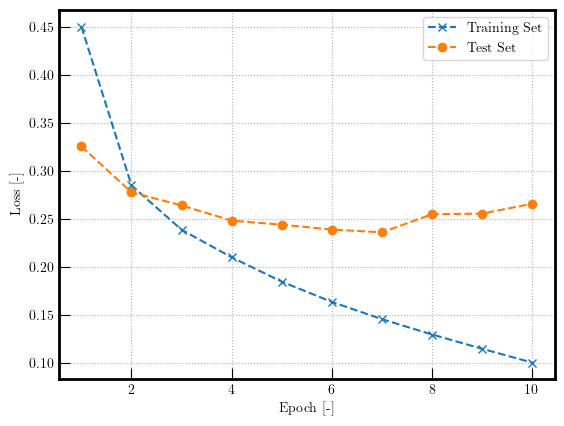

In [11]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_CNN, 'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_CNN, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss.pdf', bbox_inches='tight')

#### CNN with batch normalization

In [12]:
# Model
model_BN = CNN(batch_norm=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_BN.parameters(), lr=0.001)

In [13]:
loss_history_BN = []      # Training loss history
test_loss_history_BN = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_BN.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_BN(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_BN.append(avg_loss)

    # Testing Phase
    model_BN.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_BN(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_BN.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.4054 	 Test loss: 0.3079
Epoch 2/10 	 Training loss: 0.2710 	 Test loss: 0.2868
Epoch 3/10 	 Training loss: 0.2335 	 Test loss: 0.2718
Epoch 4/10 	 Training loss: 0.2071 	 Test loss: 0.2532
Epoch 5/10 	 Training loss: 0.1885 	 Test loss: 0.2440
Epoch 6/10 	 Training loss: 0.1698 	 Test loss: 0.2533
Epoch 7/10 	 Training loss: 0.1553 	 Test loss: 0.2420
Epoch 8/10 	 Training loss: 0.1440 	 Test loss: 0.2388
Epoch 9/10 	 Training loss: 0.1304 	 Test loss: 0.2515
Epoch 10/10 	 Training loss: 0.1178 	 Test loss: 0.2400


In [14]:
model_BN.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_BN(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_BN = 100 * correct / total
print("The accuracy of the CNN with Batch Normalization in the test set is " + str(accuracy_BN))

The accuracy of the CNN with Batch Normalization in the test set is 91.8


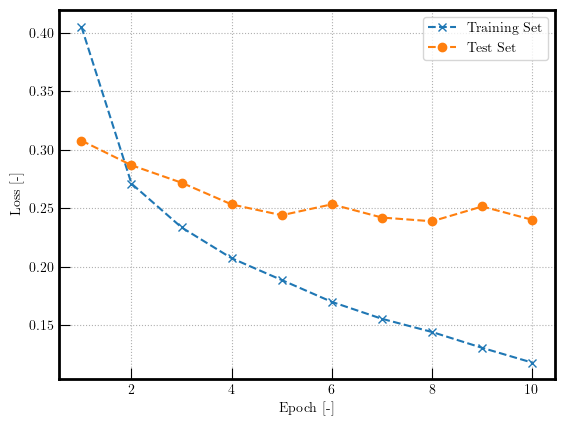

In [15]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_BN,'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_BN, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_BN.pdf', bbox_inches='tight')

#### CNN with Dropout

In [16]:
# Model
model_DO = CNN(dropout_prob=0.5)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_DO.parameters(), lr=0.001)

In [17]:
loss_history_DO = []      # Training loss history
test_loss_history_DO = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_DO.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_DO(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_DO.append(avg_loss)

    # Testing Phase
    model_DO.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_DO(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_DO.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.7582 	 Test loss: 0.4029
Epoch 2/10 	 Training loss: 0.5036 	 Test loss: 0.3347
Epoch 3/10 	 Training loss: 0.4390 	 Test loss: 0.2939
Epoch 4/10 	 Training loss: 0.3927 	 Test loss: 0.2795
Epoch 5/10 	 Training loss: 0.3570 	 Test loss: 0.2701
Epoch 6/10 	 Training loss: 0.3335 	 Test loss: 0.2635
Epoch 7/10 	 Training loss: 0.3073 	 Test loss: 0.2510
Epoch 8/10 	 Training loss: 0.2884 	 Test loss: 0.2466
Epoch 9/10 	 Training loss: 0.2732 	 Test loss: 0.2453
Epoch 10/10 	 Training loss: 0.2610 	 Test loss: 0.2400


In [18]:
model_DO.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_DO(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_DO = 100 * correct / total
print("The accuracy of the CNN with Dropout in the test set is " + str(accuracy_DO))

The accuracy of the CNN with Dropout in the test set is 91.91


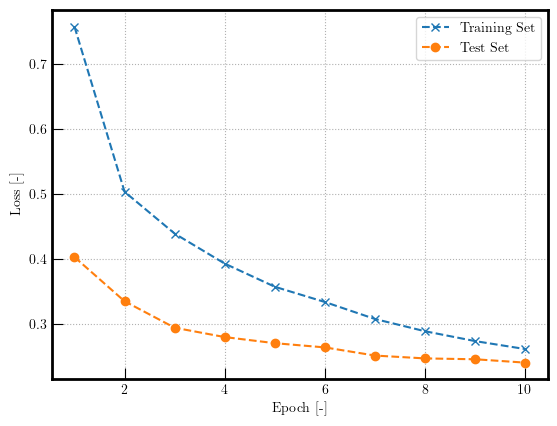

In [19]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_DO, 'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_DO, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_DO.pdf', bbox_inches='tight')

#### CNN with residual connections

In [20]:
# Model
model_RC = CNN(residual=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_RC.parameters(), lr=0.001)

In [21]:
loss_history_RC = []      # Training loss history
test_loss_history_RC = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_RC.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_RC(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_RC.append(avg_loss)

    # Testing Phase
    model_RC.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_RC(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_RC.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.4718 	 Test loss: 0.3472
Epoch 2/10 	 Training loss: 0.3045 	 Test loss: 0.3163
Epoch 3/10 	 Training loss: 0.2559 	 Test loss: 0.2554
Epoch 4/10 	 Training loss: 0.2235 	 Test loss: 0.2505
Epoch 5/10 	 Training loss: 0.2016 	 Test loss: 0.2427
Epoch 6/10 	 Training loss: 0.1839 	 Test loss: 0.2310
Epoch 7/10 	 Training loss: 0.1670 	 Test loss: 0.2336
Epoch 8/10 	 Training loss: 0.1515 	 Test loss: 0.2417
Epoch 9/10 	 Training loss: 0.1383 	 Test loss: 0.2393
Epoch 10/10 	 Training loss: 0.1247 	 Test loss: 0.2603


In [22]:
model_RC.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_RC(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_RC = 100 * correct / total
print("The accuracy of the CNN with Residual Connections in the test set is " + str(accuracy_RC))

The accuracy of the CNN with Residual Connections in the test set is 91.35


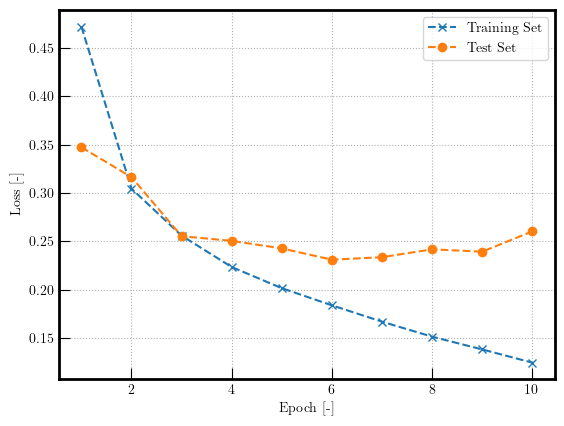

In [23]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_RC, 'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_RC, 'o--',  label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_RC.pdf', bbox_inches='tight')

#### CNN with Dropout and Batch Normalization

In [24]:
# Model
model_DOBN = CNN(dropout_prob=0.5, batch_norm=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_DOBN.parameters(), lr=0.001)

In [25]:
loss_history_DOBN = []      # Training loss history
test_loss_history_DOBN = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_DOBN.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_DOBN(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_DOBN.append(avg_loss)

    # Testing Phase
    model_DOBN.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_DOBN(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_DOBN.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.8573 	 Test loss: 0.4160
Epoch 2/10 	 Training loss: 0.6192 	 Test loss: 0.3526
Epoch 3/10 	 Training loss: 0.5502 	 Test loss: 0.3203
Epoch 4/10 	 Training loss: 0.4927 	 Test loss: 0.2946
Epoch 5/10 	 Training loss: 0.4440 	 Test loss: 0.2887
Epoch 6/10 	 Training loss: 0.4263 	 Test loss: 0.2854
Epoch 7/10 	 Training loss: 0.4091 	 Test loss: 0.2829
Epoch 8/10 	 Training loss: 0.3854 	 Test loss: 0.2604
Epoch 9/10 	 Training loss: 0.3712 	 Test loss: 0.2596
Epoch 10/10 	 Training loss: 0.3543 	 Test loss: 0.2569


In [26]:
model_DOBN.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_DOBN(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_DOBN = 100 * correct / total
print("The accuracy of the CNN with Dropout and Batch Normalization in the test set is " + str(accuracy_DOBN))

The accuracy of the CNN with Dropout and Batch Normalization in the test set is 91.29


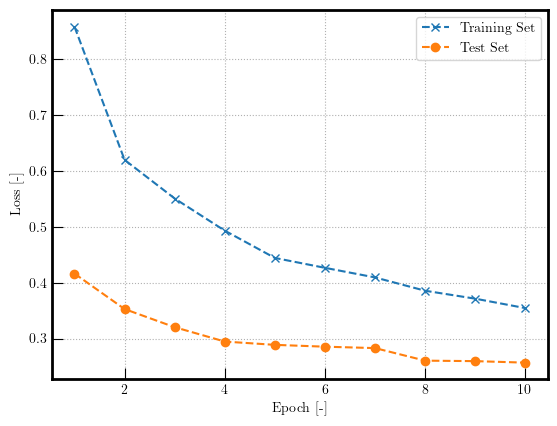

In [27]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_DOBN,'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_DOBN, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_DOBN.pdf', bbox_inches='tight')

#### CNN with Dropout and Residual Connections

In [28]:
# Model
model_DORC = CNN(dropout_prob=0.5, residual=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_DORC.parameters(), lr=0.001)

In [29]:
loss_history_DORC = []      # Training loss history
test_loss_history_DORC = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_DORC.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_DORC(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_DORC.append(avg_loss)

    # Testing Phase
    model_DORC.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_DORC(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_DORC.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.9861 	 Test loss: 0.4830
Epoch 2/10 	 Training loss: 0.6730 	 Test loss: 0.3902
Epoch 3/10 	 Training loss: 0.5757 	 Test loss: 0.3413
Epoch 4/10 	 Training loss: 0.5208 	 Test loss: 0.3256
Epoch 5/10 	 Training loss: 0.4664 	 Test loss: 0.2869
Epoch 6/10 	 Training loss: 0.4136 	 Test loss: 0.2753
Epoch 7/10 	 Training loss: 0.3782 	 Test loss: 0.2624
Epoch 8/10 	 Training loss: 0.3487 	 Test loss: 0.2551
Epoch 9/10 	 Training loss: 0.3252 	 Test loss: 0.2487
Epoch 10/10 	 Training loss: 0.3064 	 Test loss: 0.2502


In [30]:
model_DORC.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_DORC(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_DORC = 100 * correct / total
print("The accuracy of the CNN with Dropout and Residual Connections in the test set is " + str(accuracy_DORC))

The accuracy of the CNN with Dropout and Residual Connections in the test set is 91.35


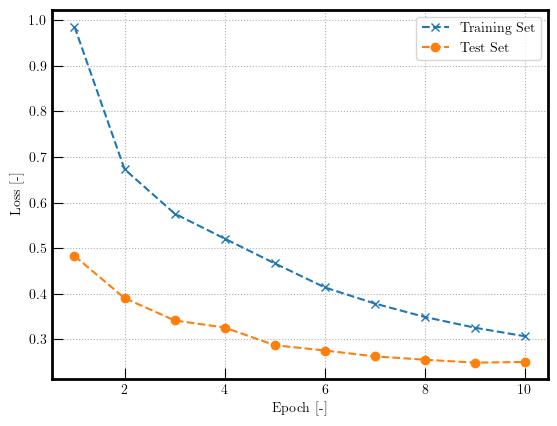

In [31]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_DORC,'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_DORC, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_DORC.pdf', bbox_inches='tight')

#### CNN with Batch Normalization and Residual Connections

In [32]:
# Model
model_BNRC = CNN(residual=True, batch_norm=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_BNRC.parameters(), lr=0.001)

In [33]:
loss_history_BNRC = []      # Training loss history
test_loss_history_BNRC = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_BNRC.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_BNRC(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_BNRC.append(avg_loss)

    # Testing Phase
    model_BNRC.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_BNRC(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_BNRC.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 0.4306 	 Test loss: 0.3364
Epoch 2/10 	 Training loss: 0.2840 	 Test loss: 0.3065
Epoch 3/10 	 Training loss: 0.2389 	 Test loss: 0.2563
Epoch 4/10 	 Training loss: 0.2093 	 Test loss: 0.2334
Epoch 5/10 	 Training loss: 0.1883 	 Test loss: 0.2472
Epoch 6/10 	 Training loss: 0.1713 	 Test loss: 0.2360
Epoch 7/10 	 Training loss: 0.1577 	 Test loss: 0.2480
Epoch 8/10 	 Training loss: 0.1411 	 Test loss: 0.2353
Epoch 9/10 	 Training loss: 0.1302 	 Test loss: 0.2507
Epoch 10/10 	 Training loss: 0.1180 	 Test loss: 0.2453


In [34]:
model_BNRC.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_BNRC(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_BNRC = 100 * correct / total
print("The accuracy of the CNN with Batch Normalization and Residual Connection in the test set is " + str(accuracy_BNRC))

The accuracy of the CNN with Batch Normalization and Residual Connection in the test set is 91.9


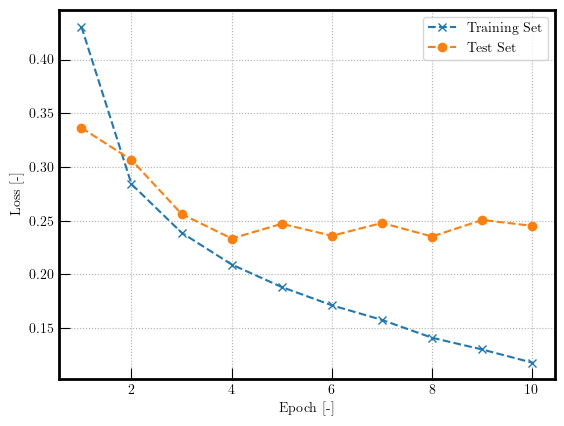

In [35]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_BNRC,'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_BNRC, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_BNRC.pdf', bbox_inches='tight')

#### CNN with all

In [36]:
# Model
model_ALL = CNN(dropout_prob=0.5, batch_norm=True, residual=True)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model_ALL.parameters(), lr=0.001)

In [37]:
loss_history_ALL = []      # Training loss history
test_loss_history_ALL = []  # Test loss history

for epoch in range(epochs):
    total_loss = 0.0

    # Training Phase
    model_ALL.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_ALL(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history_ALL.append(avg_loss)

    # Testing Phase
    model_ALL.eval()  # Set the model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():  # No gradient computation during testing
        for test_inputs, test_labels in test_loader:
            test_outputs = model_ALL(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss_history_ALL.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs} \t Training loss: {avg_loss:.4f} \t Test loss: {avg_test_loss:.4f}")

Epoch 1/10 	 Training loss: 1.0482 	 Test loss: 0.5378
Epoch 2/10 	 Training loss: 0.8044 	 Test loss: 0.4289
Epoch 3/10 	 Training loss: 0.7252 	 Test loss: 0.3661
Epoch 4/10 	 Training loss: 0.6446 	 Test loss: 0.3472
Epoch 5/10 	 Training loss: 0.5674 	 Test loss: 0.3182
Epoch 6/10 	 Training loss: 0.4599 	 Test loss: 0.2981
Epoch 7/10 	 Training loss: 0.3926 	 Test loss: 0.2829
Epoch 8/10 	 Training loss: 0.3487 	 Test loss: 0.2589
Epoch 9/10 	 Training loss: 0.3226 	 Test loss: 0.2492
Epoch 10/10 	 Training loss: 0.2937 	 Test loss: 0.2389


In [38]:
model_ALL.eval() # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradients computation
    for inputs, labels in test_loader:
        outputs = model_ALL(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy_ALL = 100 * correct / total
print("The accuracy of the CNN with all in the test set is " + str(accuracy_ALL))

The accuracy of the CNN with all in the test set is 91.51


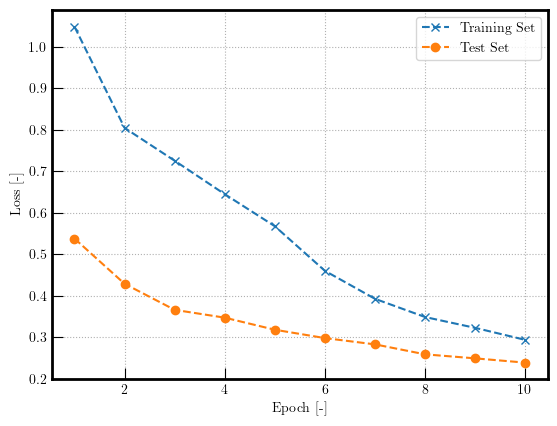

In [39]:
plt.plot(np.linspace(1,epochs, epochs), loss_history_ALL, 'x--', label = 'Training Set')
plt.plot(np.linspace(1,epochs, epochs), test_loss_history_ALL, 'o--', label = 'Test Set')
plt.legend()
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/CNN_loss_All.pdf', bbox_inches='tight')

In [40]:
Acc = pd.DataFrame({'CNN': [accuracy_CNN], 'CNN_BN': [accuracy_BN], 'CNN_DO': [accuracy_DO], 'CNN_RC': [accuracy_RC], 'CNN_DOBN':[accuracy_DOBN],  'CNN_DORC': [accuracy_DORC], 'CNN_BNRC': [accuracy_BNRC], 'CNN_ALL': [accuracy_ALL]})
Acc.to_csv('Accuracy.csv', index=False)
Acc

,CNN,CNN_BN,CNN_DO,CNN_RC,CNN_DOBN,CNN_DORC,CNN_BNRC,CNN_ALL
0,91.76,91.8,91.91,91.35,91.29,91.35,91.9,91.51


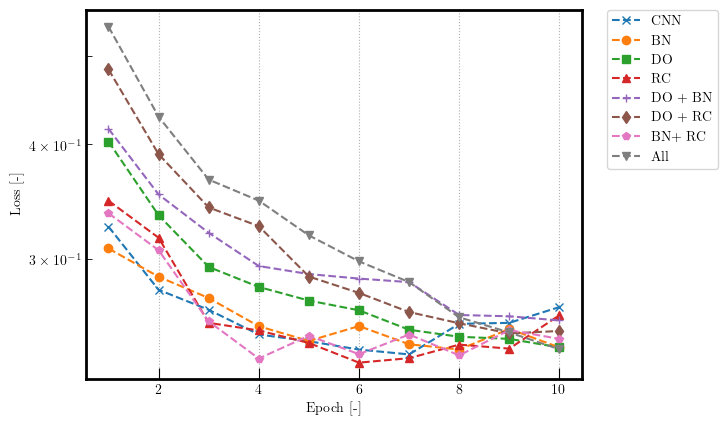

In [41]:
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_CNN, 'x--', label = 'CNN')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_BN, 'o--', label = 'BN')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_DO, 's--', label = 'DO')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_RC, '^--', label = 'RC')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_DOBN, '+--', label = 'DO + BN')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_DORC, 'd--', label = 'DO + RC')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_BNRC, 'p--', label = 'BN+ RC')
plt.semilogy(np.linspace(1,epochs, epochs), test_loss_history_ALL, 'v--', label = 'All')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(linestyle = ':')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.savefig('Plots/Test_loss_ALL.pdf', bbox_inches='tight')